In [1]:
# Доступные ресурсы
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)

print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 96
RAM GB: 1510.6
PyTorch version: 1.7.1+cu101
CUDA version: 10.1
cuDNN version: 7603
device: cuda
Tue Oct 26 10:46:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.181.07   Driver Version: 418.181.07   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:B7:00.0 Off |                    0 |
| N/A   32C    P0    75W / 350W |     13MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+---------------------------------------------------------------

In [5]:
#!git clone https://github.com/sberbank-ai/fusion_brain_aij2021.git
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install tpu_star==0.0.1rc10
!pip install albumentations==0.5.2
!pip install einops==0.3.2 
!pip install transformers==4.10.0 
!pip install colorednoise==1.1.1
!pip install catalyst==21.8 
!pip install opencv-python==4.5.3
!pip install gdown==4.0.2
!pip install pymorphy2

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu101/torch-1.7.1%2Bcu101-cp37-cp37m-linux_x86_64.whl (735.4 MB)
  Using cached https://download.pytorch.org/whl/cu101/torchvision-0.8.2%2Bcu101-cp37-cp37m-linux_x86_64.whl (12.8 MB)
  Using cached torchaudio-0.7.2-cp37-cp37m-manylinux1_x86_64.whl (7.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
ERROR: Could not find a version that satisfies the requirement opencv-python==4.5.3 (from versions: 3.4.2.17, 3.4.3.18, 3.4.4.19, 3.4.5.20, 3.4.6.27, 3.4.7.28, 3.4.8.29, 3.4.9.31, 3.4.9.33, 3.4.10.35, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4

In [2]:
import json
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import IPython.display as ipd
import os
from glob import glob
from datetime import datetime
from skimage import io
from torch import nn
from tqdm import tqdm
from einops import rearrange
from sklearn.metrics import accuracy_score

from transformers import GPT2Model, GPT2Tokenizer

from sklearn.model_selection import StratifiedKFold, train_test_split
from catalyst.data import BalanceClassSampler, DistributedSamplerWrapper
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from tpu_star.experiment import TorchGPUExperiment
import torch.nn.functional as F

#import pytorch_lightning as pl

import sys
sys.path.insert(0, 'fusion_brain_aij2021/fb_baseline')
from fb_utils.download import download_and_extract
from fb_utils.loss import LabelSmoothing, onehot
from fb_utils.metrics import cer, wer, string_accuracy, acc, vqa_evaluate, detection_evaluate
from fb_utils.handwritten import simple_detect_lang, CTCLabeling, resize_if_need, make_img_padding
from fb_utils.c2c_eval import Beam, eval_bleu
from fb_utils.detection_vqa import (vqa_evaluation, detection_evaluation,
                                              CrossAttentionLayer, MLP, FeedForwardComponent,
                                              Resnet50Backbone, DetectionCriterion)

2021-10-26 10:46:10.915771: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/home/user/conda/lib/python3.7/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


In [3]:
download_and_extract('.', 'handwritten')
download_and_extract('.', 'detection')
download_and_extract('.', 'vqa')
download_and_extract('.', 'c2c')

Downloading...
From: https://drive.google.com/uc?id=1kVFvoz6jDXckEtBQRg3pkQB_qVbsAAMG
To: /home/jovyan/quick-start/job_launch/FusionBrainConcept-AIJ2021/detection.tar.gz
100%|██████████| 131M/131M [00:01<00:00, 100MB/s]  


In [13]:
# Подготовка данных и сбор в единый DataFrame
# #
# Handwritten
# #
json_marking = json.load(open('handwritten/train_labels.json', 'rb'))
marking = []
for image_name, text in json_marking.items():
    marking.append({
        'path': image_name,
        'text': text,
        'lang': simple_detect_lang(text),
    })
df_handwritten = pd.DataFrame(marking)
df_handwritten['stage'] = 'train'
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
train_index, valid_index = next(skf.split(df_handwritten.index, df_handwritten['lang']))
df_handwritten.loc[valid_index, 'stage'] = 'valid'
# #
# Detection
# #
json_true_zsod = json.load(open('detection/true_zsOD.json', 'rb'))
json_true_zsod_train = {key: json_true_zsod[key] for key in list(json_true_zsod.keys())[:900]}
marking = []
for image_name in json_true_zsod_train:
    marking.extend([{
        'task_id': 'detection',
        'path': image_name,
        'req': request,
        'boxes': boxes,
        'lang': 'en'
    } for request, boxes in json_true_zsod_train[image_name].items() if boxes])
df_detection = pd.DataFrame(marking)
df_detection['stage'] = 'train'
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
train_index, valid_index = next(skf.split(df_detection.index, df_detection['lang']))
df_detection.loc[valid_index, 'stage'] = 'valid'
# #
# Eval Detection #
# #
marking = []
json_true_zsod_test = {key: json_true_zsod[key] for key in list(json_true_zsod.keys())[900:]}
for image_name in json_true_zsod_test:
    marking.append({
        'task_id': 'detection',
        'path': image_name,
        'req': ';'.join([request for request in json_true_zsod_test[image_name].keys()]),
        'boxes': [boxes for boxes in json_true_zsod_test[image_name].values()],
        'lang': 'en'
    })
df_eval_detection = pd.DataFrame(marking)
df_eval_detection['stage'] = 'test'
# #
# VQA
# #
json_questions = json.load(open('vqa/questions.json', 'rb'))
json_true_vqa = json.load(open('vqa/true_VQA.json', 'rb'))
marking = []
for key in json_questions:
    if json_true_vqa[key]['lang'] == 'en':
        marking.append({
            'path': str(json_questions[key]['image_id']) + '.jpg',
            'question': json_questions[key]['question'],
            'answer': json_true_vqa[key]['answer'],
            'lang': json_true_vqa[key]['lang']
        })
df_vqa = pd.DataFrame(marking)
df_vqa['stage'] = 'train'
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
train_index, valid_index = next(skf.split(df_vqa.index, df_vqa['lang']))
df_vqa.loc[valid_index, 'stage'] = 'valid'
# #
# C2C
# #
df_c2c = pd.read_json(path_or_buf='c2c/java-python.jsonl', lines=True)
train, test = train_test_split(df_c2c, test_size=0.2)
valid, test = train_test_split(test, test_size=0.05)

df_c2c.loc[train.index.to_list(), 'stage'] = 'train'
df_c2c.loc[valid.index.to_list(), 'stage'] = 'valid'
df_c2c.loc[test.index.to_list(), 'stage'] = 'test'


# #
# Merge in common set
# #
dataset = []
for image_name, text, stage in zip(df_handwritten['path'], df_handwritten['text'], df_handwritten['stage']):
    dataset.append({
        'task_id': 'handwritten',   
        'modality': 'image', 
        'input_image': image_name,
        'output_text': text,
        'stage': stage,
    })
    
for java, python, stage in zip(df_c2c['java'], df_c2c['python'], df_c2c['stage']):
    dataset.append({
        'task_id': 'trans',
        'modality': 'code',    
        'input_text': java,
        'output_text': python,
        'stage': stage,
    })
    
for image_name, text_input, text_output, stage in zip(df_vqa['path'], df_vqa['question'], df_vqa['answer'], df_vqa['stage']):
    dataset.append({
        'task_id': 'vqa', 
        'modality': 'image+text', 
        'input_image': image_name,
        'input_text': text_input,
        'output_text': text_output,
        'stage': stage,
    })
for image_name, text_input, boxes, stage in zip(df_detection['path'], df_detection['req'], df_detection['boxes'], df_detection['stage']):
    dataset.append({
        'task_id': 'detection', 
        'modality': 'image+text', 
        'input_image': image_name,
        'input_text': text_input,
        'output_boxes': boxes,
        'stage': stage,
    })
for image_name, text_input, boxes, stage in zip(df_eval_detection['path'], df_eval_detection['req'], df_eval_detection['boxes'], df_eval_detection['stage']):
    dataset.append({
        'task_id': 'detection', 
        'modality': 'image+text', 
        'input_image': image_name,
        'input_text': text_input,
        'output_boxes': boxes,
        'stage': stage,
    })

random.shuffle(dataset)
df = pd.DataFrame(dataset)
df.head(10)

,task_id,modality,input_image,input_text,output_text,stage,output_boxes
0,vqa,image+text,401556.jpg,Is the toilet functional?,yes,train,NaN
1,handwritten,image,46721.png,NaN,to,train,NaN
2,handwritten,image,40011.png,NaN,lives,train,NaN
3,handwritten,image,10196.png,NaN,the,train,NaN
4,handwritten,image,46547.png,NaN,",",train,NaN
5,handwritten,image,10472.png,NaN,has,train,NaN
6,handwritten,image,44651.png,NaN,Sir,train,NaN
7,handwritten,image,110640.png,NaN,п,train,NaN
8,trans,code,NaN,import java . util . Scanner ; public class ...,"for _ in range ( int ( input ( ) ) ) : n , m =...",train,NaN
9,handwritten,image,15639.png,NaN,will,train,NaN


<AxesSubplot:>

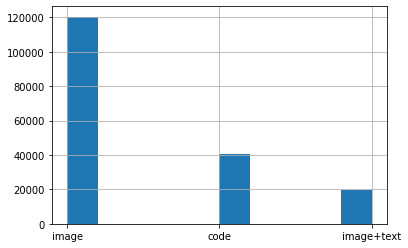

In [4]:
df['modality'].hist()

In [19]:
class DatasetRetriever(Dataset):

    def __init__(self, 
                 task_ids, 
                 input_images,
                 input_texts,
                 output_texts,
                 output_boxes,
                 ctc_labeling, 
                 tokenizer, 
                 stage, 
                 max_request_tokens_length,
                 vqa_max_tokens_length, 
                 task_augs=None):
        super().__init__()
        self.task_ids = task_ids
        
        self.input_images = input_images
        self.input_texts = input_texts
        self.output_texts = output_texts
        
        self.task_augs = task_augs or {}
        self.tokenizer = tokenizer
        self.stage = stage

        # handwritten[image]:
        self.ctc_labeling = ctc_labeling
        self.handwritten_image_w = 512
        self.handwritten_image_h = 128

        # code2code
        self.code_max_length = 512
        
        # detection[image, text]:
        self.max_request_tokens_length = max_request_tokens_length
        self.output_boxes = output_boxes
        
        # vqa[image, text]:
        self.vqa_max_tokens_length = vqa_max_tokens_length


    def __getitem__(self, idx):
        task_id = self.task_ids[idx]
        if task_id == 'handwritten':
            return self.get_handwritten_sample(idx)
        elif task_id == 'trans':
            return self.get_trans_sample(idx)
        elif task_id == 'detection':
            return self.get_detection_sample(idx)
        elif task_id == 'vqa':
            return self.get_vqa_sample(idx)
        return {'task_id': task_id}

    def get_trans_sample(self, idx):
            
        source = self.input_texts[idx]
        encoded_source = self.tokenizer.encode(str(source))
        target = self.output_texts[idx]
        encoded_target = self.tokenizer.encode(str(target))
        
        input_ids, input_labels = self.pad_and_get_mask(encoded_target, encoded_source, self.tokenizer)
        input_ids, input_labels = torch.tensor(input_ids), torch.tensor(input_labels)
        
        return {
            'task_id': self.task_ids[idx],
            'input_ids': input_ids,
            'input_labels': input_labels,
            'target': target
        }

    def get_handwritten_sample(self, idx):
        path = 'handwritten/images/' + self.input_images[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image, _ = self.resize_image(image)

        gt_text = self.output_texts[idx]
        encoded = self.ctc_labeling.encode(gt_text)

        ## Augs ##
        transforms = self.task_augs.get('handwritten')
        if transforms:
            image = transforms(image=image)['image']
        ##########

        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)

        return {
            'task_id': self.task_ids[idx],
            'image': image,
            'gt_text': gt_text,
            'encoded': torch.tensor(encoded, dtype=torch.int32),
        }
    
    def get_detection_sample(self, idx):
        path = 'detection/images/' + self.input_images[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_h, image_w, _ = image.shape
        
        ## Augs ##
        transforms = self.task_augs.get('detection')
        if transforms:
            image = transforms(image=image)['image']
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        image_name = self.input_images[idx]
        ##########
        
        ## Input tokens ##
        if self.stage == 'train' or self.stage == 'valid':
            input_text = self.input_texts[idx]
            input_tokens = self.tokenizer.encode_plus(input_text)
            input_tokens['input_ids'] = input_tokens['input_ids'][:21]
            input_tokens['attention_mask'] = input_tokens['attention_mask'][:21]
            pad_len = self.max_request_tokens_length - len(input_tokens['input_ids'])
            input_tokens['input_ids'] += [self.tokenizer.pad_token_id] * pad_len
            input_tokens['attention_mask'] += [0] * pad_len
            input_ids = torch.tensor(input_tokens['input_ids'])
            attention_mask = torch.tensor(input_tokens['attention_mask'])
        else:
            input_texts = self.input_texts[idx].split(';')
            input_ids = list(map(self.tokenizer.encode, input_texts))
            attention_mask = [[1 for _ in input_token] for input_token in input_ids]
            input_ids = [torch.tensor(input_id) for input_id in input_ids]
            attention_mask = [torch.tensor(mask) for mask in attention_mask]
        ###########
        
        ## Boxes ##
        output_boxes = self.output_boxes[idx]
        if self.stage == 'train' or self.stage == 'valid':
            output_boxes = torch.tensor(output_boxes, dtype=torch.float32)
            output_boxes[:, 0] /= image_w
            output_boxes[:, 1] /= image_h
            output_boxes[:, 2] /= image_w
            output_boxes[:, 3] /= image_h
        else:
            output_boxes = {
                input_text: boxes for input_text, boxes in zip(input_texts, output_boxes)
            }
        ##########
        
        return {
            'task_id': self.task_ids[idx],
            'image_name': image_name,
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'boxes': output_boxes,
            'size': (image_h, image_w)
        }
    
    def get_vqa_sample(self, idx): 
        path = 'vqa/images/' + self.input_images[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ## Augs ##
        transforms = self.task_augs.get('vqa')
        if transforms:
            image = transforms(image=image)['image']
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        image_name = self.input_images[idx]
        ##########
        
        ## Question and Answer ##
        input_text = self.input_texts[idx]
        input_tokens = self.tokenizer.encode(input_text)
        output_text = self.output_texts[idx]
        output_tokens = self.tokenizer.encode(output_text)
        
        if self.stage == 'train' or self.stage == 'valid':
            input_tokens, output_tokens = input_tokens[:12], output_tokens[:7]
            input_ids = input_tokens + [self.tokenizer.bos_token_id] + output_tokens + [self.tokenizer.eos_token_id]
            labels = [1] * len(input_tokens) + [2] * (len(output_tokens) + 1) + [0]
            
            pad_len = self.vqa_max_tokens_length - len(input_ids)
            input_ids += [self.tokenizer.pad_token_id] * pad_len
            labels += [0] * pad_len
        else:
            input_ids = input_tokens + [self.tokenizer.bos_token_id]
            labels = [1] * len(input_tokens) + [2]
        ##########
        
        return {
            'task_id': self.task_ids[idx],
            'image_name': image_name,
            'image': image,
            'input_ids': torch.tensor(input_ids),
            'labels': torch.tensor(labels),
            'target': output_text
        }


    def resize_image(self, image):
        image, coef = resize_if_need(image, self.handwritten_image_h, self.handwritten_image_w)
        image = make_img_padding(image, self.handwritten_image_h, self.handwritten_image_w)
        return image, coef
    
    def pad_and_get_mask(self, target, source, tokenizer):
        if self.stage == 'test':
            target = []
        while len(target) + len(source) + 2 > self.code_max_length:
            if len(target) > len(source):
                target = target[:-1]
            else:
                source = source[:-1]
        if self.stage == 'train' or self.stage == 'valid':
            inputs = source + [tokenizer.bos_token_id] + target + [tokenizer.eos_token_id]
            labels = [1] * len(source) + [2] * (len(target) + 1) + [0]

        else:
            inputs = source + [tokenizer.bos_token_id]
            labels = [1] * len(source) + [2]
            
            return inputs, labels
        
        assert len(inputs) <= self.code_max_length
        pad_len = self.code_max_length - len(inputs)
        inputs += [tokenizer.pad_token_id] * pad_len
        labels += [0] * pad_len
        assert len(inputs) == len(labels)
        
        return inputs, labels

 
    def __len__(self) -> int:
        return self.task_ids.shape[0]

    def get_task_labels(self):
        return list(self.task_ids)

In [20]:
task_augs = {
    'handwritten': A.Compose([
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.25, always_apply=False),
        A.Rotate(limit=3, interpolation=1, border_mode=0, p=0.5),
        A.JpegCompression(quality_lower=75, p=0.5),
    ], p=1.0),
    'vqa': A.Compose([
        A.Resize(224, 224, always_apply=True),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ], p=1.0),
    'detection': A.Compose([
        A.Resize(224, 224, always_apply=True),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ], p=1.0)
}

/home/user/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1748: DeprecationWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn("This class has been deprecated. Please use ImageCompression", DeprecationWarning)


In [21]:
df_train = df[df['stage'] == 'train']
df_valid = df[df['stage'] == 'valid']
df_eval = df[df['stage'] == 'test']

In [22]:
# Подготовка предобученной модели и токенизатора, а также CTC Labeling для задачи распознавания рукописного текста
CHARS = ' !"#&\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPQRSTUVWXYZ' + \
    '[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№'
ctc_labeling = CTCLabeling(CHARS)
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<s>',
            eos_token='</s>', pad_token='<pad>', unk_token='<|UNKNOWN|>', sep_token='<|SEP|>')

gpt_model = GPT2Model.from_pretrained('gpt2')
gpt_model.resize_token_embeddings(len(gpt_tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Embedding(50261, 768)

In [23]:
train_dataset = DatasetRetriever(
    task_ids=df_train['task_id'].values,
    input_images=df_train['input_image'].values,
    input_texts=df_train['input_text'].values,
    output_texts=df_train['output_text'].values,
    output_boxes=df_train['output_boxes'].values,
    stage='train',
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)
valid_dataset = DatasetRetriever(
    task_ids=df_valid['task_id'].values,
    input_images=df_valid['input_image'].values,
    input_texts=df_valid['input_text'].values,
    output_texts=df_valid['output_text'].values,
    output_boxes=df_valid['output_boxes'].values,
    stage='valid',
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)
eval_dataset = DatasetRetriever(
    task_ids=df_eval['task_id'].values,
    input_images=df_eval['input_image'].values,
    input_texts=df_eval['input_text'].values,
    output_texts=df_eval['output_text'].values,
    output_boxes=df_eval['output_boxes'].values,
    stage='test',
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

In [24]:
# Как выглядят семплы для каждой задачи
def demo_sample(sample):
    if sample['task_id'] == 'handwritten':
        print('[gt_text]:',sample['gt_text'])
        return io.imshow(sample['image'].permute(1,2,0).numpy())
    elif sample['task_id'] == 'trans':
        print('[source_text]:', gpt_tokenizer.decode(sample['input_ids'].numpy(), skip_special_tokens=True))
        print('[target_text]:', sample['target'])
        return
    elif sample['task_id'] == 'detection':
        print('[input_text]:', gpt_tokenizer.decode(sample['input_ids'].numpy(), skip_special_tokens=True))
        print('[boxes]:', sample['boxes'].numpy())
        return
    elif sample['task_id'] == 'vqa':
        print('[question and answer]:', gpt_tokenizer.decode(sample['input_ids'].numpy(), skip_special_tokens=True))
        return
    
    return sample

In [11]:
demo_sample(train_dataset[(train_dataset.task_ids == 'detection').argmax()])

[input_text]: a crowd of people on the beach
[boxes]: [[0.07617188 0.2517361  0.9140625  0.19791667]]


In [12]:
demo_sample(train_dataset[(train_dataset.task_ids == 'trans').argmax()])

[source_text]: import java. util. Scanner ;   public class Main { public static void main ( String [ ] args ) { Scanner read = new Scanner ( System. in ) ; String username = read. nextLine ( ) ; String distinctCharacters = " " ; for ( int i = 0 ; i < username. length ( ) ; i ++ ) { char current = username. charAt ( i ) ; if ( distinctCharacters. indexOf ( current ) < 0 ) distinctCharacters += current ; } if ( distinctCharacters. length ( ) % 2 == 0 ) { System. out. println ( " CHAT ▁ WITH ▁ HER! " ) ; } else { System. out. println ( " IGNORE ▁ HIM! " ) ; } read. close ( ) ; } }
print ( [ " CHAT ▁ WITH ▁ HER! ", " IGNORE ▁ HIM! " ] [ len ( { * input ( ) } ) % 2 ] ) NEW_LINE

[target_text]: print ( [ " CHAT ▁ WITH ▁ HER ! " , " IGNORE ▁ HIM ! " ] [ len ( { * input ( ) } ) % 2 ] ) NEW_LINE



In [13]:
demo_sample(train_dataset[(train_dataset.task_ids == 'vqa').argmax()])

[question and answer]: What does the bear have on his face?glasses


[gt_text]: transplants


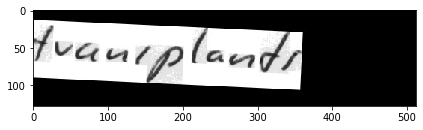

In [14]:
demo_sample(train_dataset[(train_dataset.task_ids == 'handwritten').argmax()])

In [25]:
def fb_collate_fn(batch):
    """ fusion brain collate fn """
    encoded, encoded_length, htr_images, gt_texts = [], [], [], [] # handwritten[image]
    code_input_ids, code_input_labels, code_targets = [], [], [] #code
    vqa_images, vqa_input_ids, labels, targets = [], [], [], []  # vqa[image, text]
    detection_names, detection_images, detection_input_ids, detection_attention_masks, boxes, size = [], [], [], [], [], [] # detection[image, text]
    
    for i, sample in enumerate(batch):
        if sample['task_id'] == 'handwritten':
            encoded.append(sample['encoded'])
            encoded_length.append(sample['encoded'].shape[0])
            htr_images.append(sample['image'])
            gt_texts.append(sample['gt_text'])
        elif sample['task_id'] == 'trans':
            code_input_ids.append(sample['input_ids'])
            code_input_labels.append(sample['input_labels'])
            code_targets.append(sample['target'])
        elif sample['task_id'] == 'detection':
            detection_images.append(sample['image'])
            detection_input_ids.append(sample['input_ids'])
            detection_attention_masks.append(sample['attention_mask'])
            boxes.append(sample['boxes'])
            size.append(sample['size'])
            detection_names.append(sample['image_name'])
        elif sample['task_id'] == 'vqa':
            vqa_images.append(sample['image'])
            vqa_input_ids.append(sample['input_ids'])
            labels.append(sample['labels'])
            targets.append(sample['target'])
        
    if htr_images:
        htr_images = pad_sequence(htr_images, batch_first=True)
        encoded, encoded_length = pad_sequence(encoded, batch_first=True), torch.tensor(encoded_length)
    if detection_images:
        detection_images = torch.stack(detection_images)   
    if vqa_images:
        vqa_images = torch.stack(vqa_images) 
    if detection_attention_masks and torch.is_tensor(detection_attention_masks[0]):
        detection_input_ids = pad_sequence(detection_input_ids, batch_first=True)
        detection_attention_masks = torch.stack(detection_attention_masks)
    elif detection_attention_masks:
        detection_input_ids = [input_id.unsqueeze(0) for input_id in detection_input_ids[0]]
        detection_attention_masks = [attention_mask.unsqueeze(0) for attention_mask in detection_attention_masks[0]]
    if labels:
        vqa_input_ids = pad_sequence(vqa_input_ids, batch_first=True)
        labels = pad_sequence(labels, batch_first=True)    
    if code_input_ids:
        code_input_ids = pad_sequence(code_input_ids, batch_first=True)
        code_input_labels = pad_sequence(code_input_labels, batch_first=True)
    return (htr_images, encoded, encoded_length, gt_texts), (code_input_ids, code_input_labels, code_targets), (vqa_images, vqa_input_ids, labels, targets), (detection_names, detection_images, detection_input_ids, detection_attention_masks, boxes, size)

In [26]:
class GPT2FusionBrain(nn.Module):

    def __init__(self, 
                 gpt_model, 
                 attention_config, 
                 handwritten_config, 
                 vqa_config, 
                 detection_config, 
                 **freeze_gpt_kwargs):
        super().__init__()
        self.gpt_model = gpt_model
        self.embedding_size = self.gpt_model.config.n_embd
        self.freeze_gpt(**freeze_gpt_kwargs)

        # handwritten[image] input/output layers:
        self.handwritten_config = handwritten_config
        self.handwritten_input_layer = self._build_input_net(
            input_dim=handwritten_config['patch_w']*handwritten_config['patch_h']*3,
            in_layer_sizes=handwritten_config['in_layer_sizes'],
            orth_gain=handwritten_config['orth_gain'],
            dropout=handwritten_config['dropout'],
        )
        self.handwritten_lstm = nn.LSTM(
            self.embedding_size, self.embedding_size // 2,
            handwritten_config['lstm_num_layers'], dropout=handwritten_config['dropout'],
            batch_first=True, bidirectional=True
        )
        self.handwritten_output_layer = self._build_output_net(
            output_dim=handwritten_config['output_dim'],
            out_layer_sizes=handwritten_config['out_layer_sizes'],
            dropout=handwritten_config['dropout'],
        )
        print('=== HANDWRITTEN TASK ===')
        self._calculate_trainable_params([
            self.handwritten_input_layer,
            self.gpt_model, 
            self.handwritten_lstm, 
            self.handwritten_output_layer,
        ], without_emb=True)
        print('=== === === === ===')
        #####

        # code2code
        self.beam_size=3
        self.sos_id=self.gpt_model.config.bos_token_id
        self.eos_id=self.gpt_model.config.eos_token_id
        self.lm_head = nn.Linear(self.gpt_model.config.n_embd, self.gpt_model.config.vocab_size, bias=False)

        print('=== C2C TASK ===')
        self._calculate_trainable_params([self.gpt_model, self.lm_head])
        print('=== === === === ===')
        
        ## zhOD[image, text] and VQA[image, text] layers:
        self.attention_config = attention_config
        self.backbone = ResnetBackbone(pretrained=True)
        self.input_proj = nn.Conv2d(self.backbone.num_channels, self.embedding_size, kernel_size=1)
        self.cross_attention = nn.ModuleList([
            CrossAttentionLayer(self.embedding_size, attention_config['num_heads'], attention_config['pf_dim'])
            for _ in range(attention_config['num_attention_layers'])
        ])
        #####
        
        # detection[image, text] input/output layers:
        self.detection_config = detection_config
        self.detection_pool = nn.AdaptiveMaxPool2d((detection_config["num_queries"], None))
        self.bbox_embed = MLP(self.embedding_size, self.embedding_size, 5, detection_config['num_mlp_layers'])
        print('=== DETECTION TASK ===')
        self._calculate_trainable_params([
            self.backbone,
            self.gpt_model, 
            self.input_proj,
            self.cross_attention,
            self.bbox_embed
        ])
        print('=== === === === ===')
        #####
        
         # vqa[image, text] input/output layers:
        self.vqa_config = vqa_config
        self.tokens_embed = nn.Linear(self.embedding_size, vqa_config['tokens_num'])
        print('=== VQA TASK ===')
        self._calculate_trainable_params([
            self.backbone,
            self.gpt_model, 
            self.input_proj,
            self.cross_attention,
            self.bbox_embed
        ])
        print('=== === === === ===')
        #####
        
        print('=== COMMON PARAMS ===')
        self._calculate_common_params()
        print('=== === === === ===')


    def forward(self, task_id, **kwargs):
        if task_id == 'handwritten':
            return self.forward_handwritten(**kwargs)
        elif task_id == 'trans':
            return self.forward_trans(**kwargs)
        elif task_id == 'vqa':
            return self.forward_vqa(**kwargs)
        elif task_id == 'detection':
            return self.forward_detection(**kwargs)

    def forward_trans(self, input_ids, input_labels=None, eval_bleu=False, past=None):
        if not eval_bleu:
            attn_mask = torch.tensor(input_labels.clone().detach() != 0, dtype=torch.uint8)
            attn_mask = attn_mask.to(input_labels.device)
            outputs = self.gpt_model(input_ids, attention_mask=attn_mask)
            x = self.lm_head(outputs[0])
            return x
        else:
            if past != None:
                outputs = self.gpt_model(input_ids, past_key_values=past)
                logits = self.lm_head(outputs[0])
                return logits, outputs[1]
            else:
                outputs = self.gpt_model(input_ids)[1]
                return outputs

    def forward_handwritten(self, images):
        x = rearrange(images, 'b c (h p1) (w p2) -> b (w) (h) (p1 p2 c)',
                      p1=self.handwritten_config['patch_h'], p2=self.handwritten_config['patch_w'])
        x = x.squeeze(2)
        x = self.handwritten_input_layer(x)
        # Fusion Brain
        transformer_outputs = self.gpt_model(inputs_embeds=x, output_hidden_states=True)
        x = transformer_outputs.last_hidden_state
        #####
        x, _ = self.handwritten_lstm(x)        
        x = self.handwritten_output_layer(x)
        return x

    def forward_vqa(self, images, tokens, labels):
        back_out = self.backbone(images)
        patchs = self.input_proj(back_out).flatten(-2).transpose(-1, -2)
        attention_mask = torch.tensor(labels.clone().detach() != 0, dtype=torch.uint8)
        attention_mask = attention_mask.to(labels.device)
        # Fusion Brain
        img_emb = self.gpt_model(inputs_embeds=patchs).last_hidden_state
        tokens_emb = self.gpt_model(input_ids=tokens, attention_mask=attention_mask).last_hidden_state
        #####
        for layer in self.cross_attention:
            tokens_emb, _ = layer(tokens_emb, img_emb)
            
        output_logits = self.tokens_embed(tokens_emb)
        
        return output_logits
    
    def forward_detection(self, images, tokens, attention_masks):
        back_out = self.backbone(images)
        patchs = self.input_proj(back_out).flatten(-2).transpose(-1, -2)
        # Fusion Brain
        img_embs = self.gpt_model(inputs_embeds=patchs).last_hidden_state
        tokens_embs = self.gpt_model(input_ids=tokens, attention_mask=attention_masks).last_hidden_state
        #####
        norm_img_embs = F.normalize(img_embs, p=2, dim=-1)
        norm_tokens_embs = F.normalize(tokens_embs, p=2, dim=-1)
        
        text_masks = attention_masks.type(torch.bool)
        for layer in self.cross_attention:
            img_embs, _ = layer(img_embs, tokens_embs, ~text_masks)
        img_embs = self.detection_pool(img_embs)
        
        output_logits = self.bbox_embed(img_embs).sigmoid()
        out = {
            'pred_logits': output_logits,
            'proj_queries': norm_img_embs,
            'proj_tokens':norm_tokens_embs,
        }

        return out

    def freeze_gpt(self, freeze_pos=True, freeze_ln=True, freeze_attn=True, freeze_ff=True, freeze_other=True):
        for name, p in self.gpt_model.named_parameters():
            name = name.lower()
            if 'ln' in name or 'norm' in name:
                p.requires_grad = not freeze_ln
            elif 'wpe' in name or 'position_embeddings' in name or 'pos_drop' in name:
                p.requires_grad = not freeze_pos
            elif 'mlp' in name:
                p.requires_grad = not freeze_ff
            elif 'attn' in name:
                p.requires_grad = not freeze_attn
            else:
                p.requires_grad = not freeze_other

    def _build_input_net(self, input_dim, in_layer_sizes=None, orth_gain=1.41, dropout=0.1):
        """ вспомогательный метод для сборки input слоя, который приводит размер входящих данный к эмбеддингу gpt """
        in_layer_sizes = [] if not in_layer_sizes else in_layer_sizes
        in_layers = []
        last_output_size = input_dim
        for size in in_layer_sizes:
            layer = nn.Linear(last_output_size, size)
            if orth_gain is not None:
                torch.nn.init.orthogonal_(layer.weight, gain=orth_gain)
            layer.bias.data.zero_()

            in_layers.append(layer)
            in_layers.append(nn.ReLU())
            in_layers.append(nn.Dropout(dropout))
            last_output_size = size

        final_linear = nn.Linear(last_output_size, self.embedding_size)
        if orth_gain is not None:
            torch.nn.init.orthogonal_(final_linear.weight, gain=orth_gain)
        final_linear.bias.data.zero_()

        in_layers.append(final_linear)
        in_layers.append(nn.Dropout(dropout))

        return nn.Sequential(*in_layers)
    
    def _build_output_net(self, output_dim, embedding_size=None, out_layer_sizes=None, dropout=0.1):
        """ вспомогательный метод для сборки output слоя """
        out_layer_sizes = [] if not out_layer_sizes else out_layer_sizes
        out_layers = []
        last_output_size = embedding_size or self.embedding_size
        for size in out_layer_sizes:
            out_layers.append(nn.Linear(last_output_size, size))
            out_layers.append(nn.ReLU())
            out_layers.append(nn.Dropout(dropout))
            last_output_size = size
        out_layers.append(nn.Linear(last_output_size, output_dim))
        return nn.Sequential(*out_layers)

    def _calculate_trainable_params(self, layers, without_emb=False):
        trainable_params, all_used_params = 0, 0
        for layer in layers:
            if layer == self.gpt_model and without_emb:
                layer_parameters = list(layer.parameters())[2:]
            else:
                layer_parameters = list(layer.parameters())
            trainable_params += sum(p.numel() for p in layer_parameters if p.requires_grad)
            all_used_params += sum(p.numel() for p in layer_parameters)        
        print('trainable_params:', trainable_params)
        print(' all_used_params:', all_used_params)
        print('               %:', round(trainable_params/all_used_params*100, 2))

    def _calculate_common_params(self):
        all_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        common_params = sum(p.numel() for p in list(self.gpt_model.parameters())[2:])
        print('common_params:', common_params)
        print('   all_params:', all_params)
        print('            %:', round(common_params/all_params*100, 2))     
        print('trainable_params:', trainable_params)
        print('               %:', round(trainable_params/all_params*100, 2))

In [27]:
handwritten_config = {
    'patch_w': 8,
    'patch_h': 128,
    'in_layer_sizes': [8*128*3],
    'out_layer_sizes': [64],
    'orth_gain': 1.41,
    'dropout': 0.1,
    'lstm_num_layers': 3,
    'output_dim': len(ctc_labeling), # 152
}

attention_config = {
    'num_attention_layers': 3,
    'num_heads': 8,
    'pf_dim': 2048,
}

vqa_config = {
    'tokens_num': len(gpt_tokenizer),
}

detection_config = {
    'num_mlp_layers': 3,
    'num_queries': 8
}

In [28]:
model = GPT2FusionBrain(
    gpt_model,
    attention_config=attention_config,
    handwritten_config=handwritten_config,
    vqa_config=vqa_config,
    detection_config=detection_config
)

=== HANDWRITTEN TASK ===
trainable_params: 22494680
 all_used_params: 146937560
               %: 15.31
=== === === === ===
=== C2C TASK ===
trainable_params: 38600448
 all_used_params: 163043328
               %: 23.67
=== === === === ===
=== DETECTION TASK ===
trainable_params: 29810477
 all_used_params: 154253357
               %: 19.33
=== === === === ===
=== VQA TASK ===
trainable_params: 29810477
 all_used_params: 154253357
               %: 19.33
=== === === === ===
=== COMMON PARAMS ===
common_params: 124442880
   all_params: 253999194
            %: 48.99
trainable_params: 129556314
               %: 51.01
=== === === === ===


# Experiments

In [29]:
# Скрипты для обучения и оценки качества модели


class FusionBrainExperiment(TorchGPUExperiment):

    handwritten_criterion = torch.nn.CTCLoss(zero_infinity=True)
    ctc_labeling = ctc_labeling
    detection_criterion = DetectionCriterion(['boxes', 'classification', 'contrastive'], 0.07)
    detection_loss_weights = [1.0, 1.0, 1.0, 1.0]
    vqa_criterion = nn.CrossEntropyLoss()
    c2c_criterion = nn.CrossEntropyLoss()
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<s>',
            eos_token='</s>', pad_token='<pad>', unk_token='<|UNKNOWN|>', sep_token='<|SEP|>')
    
#     def custom_action_before_train_one_epoch(self, test_loader):
#         run_evaluation(test_loader, self.model, tokenizer=self.tokenizer)
        
#     def _custom_action_before_train_one_epoch(self):
#         self._wipe_memory()
#         self.custom_action_before_train_one_epoch(test_loader)

    def calculate_handwritten_metrics(self, gt_texts, outputs):
        pred_texts = []
        for encoded in outputs.argmax(2).data.cpu().numpy():
            pred_texts.append(self.ctc_labeling.decode(encoded))
        texts = [self.ctc_labeling.preprocess(text) for text in gt_texts]
        return {
            'h_cer': cer(pred_texts, texts),
            'h_wer': wer(pred_texts, texts),
            'h_acc': string_accuracy(pred_texts, texts),
        }

    def handle_one_batch(self, batch):
        (htr_images, encoded, encoded_length, gt_texts), (code_input_ids, code_input_labels, code_targets), (vqa_images, vqa_input_ids, labels, targets), (detection_names, detection_images, detection_input_ids, detection_attention_masks, boxes, size) = batch
        losses = []
        metrics = {}

        if len(htr_images) > 0:
            bs = htr_images.shape[0]
            images = htr_images.to(self.device, dtype=torch.float32)
            encoded_length = encoded_length.to(self.device, dtype=torch.int32)
            encoded = encoded.to(self.device, dtype=torch.int32)
            handwritten_outputs = self.model('handwritten', images=images)
            preds_size = torch.IntTensor([handwritten_outputs.size(1)] * bs)
            preds = handwritten_outputs.log_softmax(2).permute(1, 0, 2)
            handwritten_loss = self.handwritten_criterion(preds, encoded, preds_size, encoded_length)
            handwritten_metrics = self.calculate_handwritten_metrics(gt_texts, handwritten_outputs)
            metrics.update(handwritten_metrics)
            metrics['h_loss'] = handwritten_loss.detach().cpu().item()
            losses.append(handwritten_loss)

        if len(code_input_ids) > 0:
            bs = code_input_ids.shape[0]
            code_input_ids = code_input_ids.to(self.device, dtype=torch.long) 
            code_input_labels = code_input_labels.to(self.device, dtype=torch.long) 
            loss_mask = torch.tensor(code_input_labels.clone().detach() == 2, dtype=torch.uint8)
            loss_mask = loss_mask.to(self.device)
            lm_logits = self.model('trans', input_ids=code_input_ids, input_labels=code_input_labels)
            c_labels = code_input_ids
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = c_labels[..., 1:].contiguous()
            
            flatten_shift_loss_mask = loss_mask[..., :-1].contiguous().view(-1)
            ids = torch.nonzero(flatten_shift_loss_mask).view(-1)
            c2c_loss = self.c2c_criterion(shift_logits.view(-1, shift_logits.size(-1))[ids], shift_labels.view(-1)[ids])
            metrics['c2c_loss'] = c2c_loss.detach().cpu().item()
            losses.append(c2c_loss)
            
        if len(labels) > 0:
            images = vqa_images.to(self.device, dtype=torch.float32)
            input_ids = vqa_input_ids.to(self.device, dtype=torch.long)
            labels = labels.to(self.device, dtype=torch.float32)
            loss_mask = torch.tensor(labels.clone().detach() == 2, dtype=torch.uint8)
            loss_mask = loss_mask.to(self.device)
            lm_logits = self.model('vqa', images=images, tokens=input_ids, labels=labels)
            labels = input_ids
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            flatten_shift_loss_mask = loss_mask[..., :-1].contiguous().view(-1)
            ids = torch.nonzero(flatten_shift_loss_mask).view(-1)
            vqa_loss = self.vqa_criterion(shift_logits.view(-1, shift_logits.size(-1))[ids], shift_labels.view(-1)[ids])
            metrics['vqa_loss'] = vqa_loss.detach().cpu().item()
            losses.append(vqa_loss)
            
        if len(boxes) > 0:
            images = detection_images.to(self.device, dtype=torch.float32)
            input_ids = detection_input_ids.to(self.device, dtype=torch.long) 
            attention_masks = detection_attention_masks.to(self.device, dtype=torch.long) 
            boxes = [boxes_per_label.to(self.device, dtype=torch.float) for boxes_per_label in boxes]
            detection_outputs = self.model('detection', images=images, tokens=input_ids, attention_masks=attention_masks)
            detection_loss = self.detection_criterion(detection_outputs, boxes)
            #detection_loss = sum([
            #    loss * weight for loss, weight in zip(detection_loss.values(), self.detection_loss_weights)
            #])
            #metrics['detection_acc'] = acc(targets.argmax(axis=1), sentiment_outputs)
            metrics['loss_giou'] = detection_loss['loss_giou'].detach().cpu().item()
            metrics['loss_bbox'] = detection_loss['loss_bbox'].detach().cpu().item()
            metrics['loss_contrastive'] = detection_loss['loss_contrastive'].detach().cpu().item()
            metrics['loss_classification'] = detection_loss['loss_classification'].detach().cpu().item()
            losses.append(detection_loss['loss_giou'])
            losses.append(detection_loss['loss_bbox'])
            losses.append(detection_loss['loss_contrastive'])
            losses.append(detection_loss['loss_classification'])

        #loss = sum(losses)
        loss = sum([loss * weight for loss, weight in zip(losses, self.detection_loss_weights)])
        
        #print(loss)
        self.metrics.update(loss=loss.detach().cpu().item(), **metrics)
        
        #self.metrics.update(loss=loss.item(), **metrics)

        if self.is_train:
            loss.backward()
            self.optimizer_step()
            self.optimizer.zero_grad()
            self.scheduler.step()


def run_evaluation(loader, model, tokenizer=None, device=torch.device('cuda:0')):
    result = []
    true_json_detection = {}
    pred_json_detection = {}
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader):
            (htr_images, encoded, encoded_length, gt_texts), (code_input_ids, code_input_labels, code_targets), (vqa_images, vqa_input_ids, labels, targets), (detection_names, detection_images, detection_input_ids, detection_attention_masks, boxes, size) = batch
            if len(htr_images) > 0:
                images = htr_images.to(device, dtype=torch.float32)
                handwritten_outputs = model('handwritten', images=images)
                for encoded, gt_text in zip(handwritten_outputs.argmax(2).data.cpu().numpy(), gt_texts):
                    pred_text = ctc_labeling.decode(encoded)
                    result.append({
                        'task_id': 'handwritten',
                        'gt_output': gt_text,
                        'pred_output': pred_text,
                    })

            if len(code_input_ids) > 0:
                code_input_ids = code_input_ids.to(device, dtype=torch.long)
                code_input_labels = code_input_labels.to(device, dtype=torch.long)
                loss_mask = torch.tensor(code_input_labels.clone().detach() == 2, dtype=torch.uint8)
                loss_mask = loss_mask.to(device)
                hidden_states = model('trans', input_ids=code_input_ids, input_labels=code_input_labels, eval_bleu=True)
                bleu_score, _ = eval_bleu(model, hidden_states, input_ids=code_input_ids, beam_size=5, tokenizer=tokenizer, targets=code_targets)
                result.append({
                        'task_id': 'trans',
                        'true_text': code_targets,
                        'bleu_score': bleu_score,
                })
                
            if len(labels) > 0:
                images = vqa_images.to(device, dtype=torch.float32)
                input_ids = vqa_input_ids.to(device, dtype=torch.long)
                labels = labels.to(device, dtype=torch.float) 
                attention_mask = torch.tensor(labels.clone().detach() != 0, dtype=torch.uint8)
                attention_mask = attention_mask.to(labels.device)
                vqa_outputs = vqa_evaluation(model, images, input_ids, attention_mask, 10)
                for target, pred_labels in zip(targets, vqa_outputs.argmax(-1).cpu().numpy()):
                    result.append({
                        'task_id': 'vqa',
                        'gt_output': target,
                        'pred_output': gpt_tokenizer.decode(pred_labels).split(gpt_tokenizer.eos_token)[0],
                    })
                    
            if len(boxes) > 0:
                images = detection_images.to(device, dtype=torch.float32)
                input_ids = [input_id.to(device, dtype=torch.long) for input_id in detection_input_ids]
                attention_masks = [attention_mask.to(device, dtype=torch.long) for attention_mask in detection_attention_masks]
                detection_outputs = detection_evaluation(model, images, input_ids, attention_masks, 0.12, 0.5)
                img_h, img_w = size[0]
                for i in range(len(detection_outputs)):
                    if detection_outputs[i].numel() != 0:
                        detection_outputs[i][:, 0] = detection_outputs[i][:, 0] * img_w
                        detection_outputs[i][:, 2] = detection_outputs[i][:, 2] * img_w
                        detection_outputs[i][:, 1] = detection_outputs[i][:, 1] * img_h
                        detection_outputs[i][:, 3] = detection_outputs[i][:, 3] * img_h
                image_name = detection_names[0]
                for boxes_for_img in boxes:
                    true_json_detection[image_name] = boxes_for_img
                    pred_json_detection[image_name] = {
                        input_text: output.type(torch.int32).cpu().tolist()
                        for input_text, output in zip(boxes_for_img.keys(), detection_outputs)
                    }
                result.append({
                        'task_id': 'detection',
                    })
                
    result = pd.DataFrame(result)

    handwritten_result = result[result['task_id'] == 'handwritten']
    if handwritten_result.shape[0]:
        print('= Handwritten =')
        print('CER:', round(cer(handwritten_result['pred_output'], handwritten_result['gt_output']), 3))
        print('WER:', round(wer(handwritten_result['pred_output'], handwritten_result['gt_output']), 3))
        print('ACC:', round(string_accuracy(handwritten_result['pred_output'], handwritten_result['gt_output']), 3))
        print('=== === === ===')
        
    trans_result = result[result['task_id'] == 'trans']   
    if trans_result.shape[0]:
        print('== C2C ==')
        print('meanBLEU:', np.mean(trans_result['bleu_score']))
        print('=== === === ===')
        
    vqa_result = result[result['task_id'] == 'vqa']
    if vqa_result.shape[0]:
        print('== VQA ==')
        print('ACC:', round(vqa_evaluate(vqa_result), 3))
        print('=== === === ===')
        
    
    if len(true_json_detection):
        print('== Detection ==')
        #print(true_json_detection)
        #print("PRED")
        #print(pred_json_detection)
        print('ACC:', round(detection_evaluate(true_json_detection, pred_json_detection), 3))
        print('=== === === ===')

    return result


def load_model(model, experiment_name):
    paths = sorted(glob(f'./saved_models/{experiment_name}*'))
    if len(paths) == 0:
        print('Warning! Model not found')
        return model
    checkpoint_path = paths[-1] + '/last.pt'
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
#     metrics = defaultdict(list)
#     for epoch in range(len(checkpoint['metrics_state_dict']['train_metrics'])):
#         train_metrics = checkpoint['metrics_state_dict']['train_metrics'][epoch]['avg']
#         valid_metrics = checkpoint['metrics_state_dict']['valid_metrics'][epoch]['avg']
#         for key in train_metrics.keys():
#             metrics[f'train_{key}'].append(train_metrics[key])
#             metrics[f'valid_{key}'].append(valid_metrics[key])
#         metrics['epoch'].append(epoch)        
#     metrics = pd.DataFrame(metrics)
    return model
#     return model

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Code To Code

In [23]:
# Запуск обучения c2c[code]

DEMO_LOGS = False 

trans_train = df[(df['task_id'] == 'trans') & (df['stage'] == 'train')]
trans_valid = df[(df['task_id'] == 'trans') & (df['stage'] == 'valid')]
trans_test = df[(df['task_id'] == 'trans') & (df['stage'] == 'test')]


trans_train_dataset = DatasetRetriever(
    task_ids=trans_train['task_id'].values,
    input_images=trans_train['input_image'].values,
    input_texts=trans_train['input_text'].values,
    output_texts=trans_train['output_text'].values,
    output_boxes=trans_train['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='train',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

trans_valid_dataset = DatasetRetriever(
    task_ids=trans_valid['task_id'].values,
    input_images=trans_valid['input_image'].values,
    input_texts=trans_valid['input_text'].values,
    output_texts=trans_valid['output_text'].values,
    output_boxes=trans_valid['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='valid',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

trans_test_dataset = DatasetRetriever(
    task_ids=trans_test['task_id'].values,
    input_images=trans_test['input_image'].values,
    input_texts=trans_test['input_text'].values,
    output_texts=trans_test['output_text'].values,
    output_boxes=trans_test['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='test',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)


#model.freeze_gpt()
model.freeze_gpt(freeze_pos=False, freeze_ln=False, freeze_attn=True, freeze_ff=True, freeze_other=False)

CONFIG = {
    'description': 'Обучение c2c task',
    'experiment_name': f'fusion-brain-c2c-{round(datetime.utcnow().timestamp())}',
    'lr': 0.000005,
    'bs': 4,
    'num_epochs': 25,
    'max_lr': 0.001,
    'pct_start': 0.1,
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    trans_train_dataset,
    batch_size=CONFIG['bs'],
    sampler=RandomSampler(trans_train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=2,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    trans_valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=SequentialSampler(trans_valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)
test_loader = torch.utils.data.DataLoader(
    trans_test_dataset,
    batch_size=1,
    sampler=SequentialSampler(trans_test_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-detection-1631794561/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=False,
        last_saving=True,
        #test_loader=test_loader #before each epoch BLEU is calculated (custom_action_before_train_one_epoch in Experiment)
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()


2021-10-26T08:08:34.473560
lr: 3.9999999999999996e-05


/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Token indices sequence length is longer than the specified maximum sequence length for this model (1873 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1873 > 1024). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

In [26]:
# c2c evaluation
c2c_valid = df[(df['task_id'] == 'trans') & (df['stage'] == 'test')][:100]

c2c_eval_dataset = DatasetRetriever(
    task_ids=c2c_valid['task_id'].values,
    input_images=c2c_valid['input_image'].values,
    input_texts=c2c_valid['input_text'].values,
    output_texts=c2c_valid['output_text'].values,
    output_boxes=c2c_valid['output_boxes'].values,
    stage='test',
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

model, _ = load_model(model, 'fusion-brain-c2c')
model = model.to(device)

valid_loader = torch.utils.data.DataLoader(
    c2c_eval_dataset,
    batch_size=1,
    sampler=SequentialSampler(c2c_eval_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

evaluation_result = run_evaluation(valid_loader, model, tokenizer=gpt_tokenizer)

100%|██████████| 100/100 [02:16<00:00,  1.36s/it]

== C2C ==
meanBLEU: 26.071800000000003
=== === === ===


## Handwritten

In [ ]:
# Запуск обучения handwritten[image]

DEMO_LOGS = False #@param {type:"boolean"}

handwritten_train = df[(df['task_id'] == 'handwritten') & (df['stage'] == 'train')]
handwritten_valid = df[(df['task_id'] == 'handwritten') & (df['stage'] == 'valid')]

handwritten_train_dataset = DatasetRetriever(
    task_ids=handwritten_train['task_id'].values,
    input_images=handwritten_train['input_image'].values,
    input_texts=handwritten_train['input_text'].values,
    output_texts=handwritten_train['output_text'].values,
    output_boxes=handwritten_train['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='train',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)
handwritten_valid_dataset = DatasetRetriever(
    task_ids=handwritten_valid['task_id'].values,
    input_images=handwritten_valid['input_image'].values,
    input_texts=handwritten_valid['input_text'].values,
    output_texts=handwritten_valid['output_text'].values,
    output_boxes=handwritten_valid['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='valid',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

CONFIG = {
    'description': 'Обучение handwritten task',
    'experiment_name': f'fusion-brain-handwritten-{round(datetime.utcnow().timestamp())}',
    'lr': 0.00008,
    'bs': 64,
    'num_epochs': 50,
    'max_lr': 0.001,
    'pct_start': 0.1,
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    handwritten_train_dataset,
    batch_size=CONFIG['bs'],
    sampler=RandomSampler(handwritten_train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=4,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    handwritten_valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=SequentialSampler(handwritten_valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=4,
    collate_fn=fb_collate_fn,
)

#model, _ = load_model(model, 'fusion-brain-c2c')
model.freeze_gpt()
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-handwritten-1631797524/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=False,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()

## VQA

In [25]:
# Запуск обучения vqa[image+text]

DEMO_LOGS = False

vqa_train = df[(df['task_id'] == 'vqa') & (df['stage'] == 'train')]
vqa_valid = df[(df['task_id'] == 'vqa') & (df['stage'] == 'valid')]

vqa_train_dataset = DatasetRetriever(
    task_ids=vqa_train['task_id'].values,
    input_images=vqa_train['input_image'].values,
    input_texts=vqa_train['input_text'].values,
    output_texts=vqa_train['output_text'].values,
    output_boxes=vqa_train['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='train',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)
vqa_valid_dataset = DatasetRetriever(
    task_ids=vqa_valid['task_id'].values,
    input_images=vqa_valid['input_image'].values,
    input_texts=vqa_valid['input_text'].values,
    output_texts=vqa_valid['output_text'].values,
    output_boxes=vqa_valid['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='valid',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

CONFIG = {
    'description': 'Обучение vqa task',
    'experiment_name': f'fusion-brain-vqa-{round(datetime.utcnow().timestamp())}',
    'lr': 0.000004,
    'bs': 64,
    'num_epochs': 20,
    'max_lr': 0.001,
    'pct_start': 0.1,
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    vqa_train_dataset,
    batch_size=CONFIG['bs'],
    sampler=RandomSampler(vqa_train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=4,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    vqa_valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=SequentialSampler(vqa_valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=4,
    collate_fn=fb_collate_fn,
)

#model, _ = load_model(model, 'fusion-brain-handwritten')
model.freeze_gpt(freeze_pos=False, freeze_ln=False, freeze_attn=True, freeze_ff=True, freeze_other=False)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-vqa-1631794561/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=True,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()


2021-10-26T08:16:09.280235
lr: 3.9999999999999996e-05


/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train epoch 0, time: 48.6s, loss=4.79440, vqa_loss=4.79440
Valid epoch 0, time: 4.7s, loss=3.47487, vqa_loss=3.47487

2021-10-26T08:17:17.206440
lr: 0.0005226089222300143


KeyboardInterrupt: 

In [25]:
# vqa evaluation
vqa_valid = df[(df['task_id'] == 'vqa') & (df['stage'] == 'valid')][:1000]

vqa_eval_dataset = DatasetRetriever(
    task_ids=vqa_valid['task_id'].values,
    input_images=vqa_valid['input_image'].values,
    input_texts=vqa_valid['input_text'].values,
    output_texts=vqa_valid['output_text'].values,
    output_boxes=vqa_valid['output_boxes'].values,
    stage='valid',
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

model = model.to(device)
#model.load_state_dict(torch.load('fusion.pt')['model_state_dict'])

valid_loader = torch.utils.data.DataLoader(
    vqa_eval_dataset,
    batch_size=1,
    sampler=SequentialSampler(vqa_eval_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

evaluation_result = run_evaluation(valid_loader, model, tokenizer=gpt_tokenizer)

100%|██████████| 1000/1000 [02:18<00:00,  7.22it/s]

== VQA ==
ACC: 0.3
=== === === ===


## Detection

In [26]:
# Запуск обучения detection[image+text]

DEMO_LOGS = False

detection_train = df[(df['task_id'] == 'detection') & (df['stage'] == 'train')]
detection_valid = df[(df['task_id'] == 'detection') & (df['stage'] == 'valid')]

detection_train_dataset = DatasetRetriever(
    task_ids=detection_train['task_id'].values,
    input_images=detection_train['input_image'].values,
    input_texts=detection_train['input_text'].values,
    output_texts=detection_train['output_text'].values,
    output_boxes=detection_train['output_boxes'].values,
    stage='train',
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)
detection_valid_dataset = DatasetRetriever(
    task_ids=detection_valid['task_id'].values,
    input_images=detection_valid['input_image'].values,
    input_texts=detection_valid['input_text'].values,
    output_texts=detection_valid['output_text'].values,
    output_boxes=detection_valid['output_boxes'].values,
    stage='valid',
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

CONFIG = {
    'description': 'Обучение detection task',
    'experiment_name': f'fusion-brain-detection-{round(datetime.utcnow().timestamp())}',
    'lr': 0.000004,
    'bs': 32,
    'num_epochs': 60,
    'max_lr': 0.0001,
    'pct_start': 0.1,
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    detection_train_dataset,
    batch_size=CONFIG['bs'],
    sampler=RandomSampler(detection_train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=4,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    detection_valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=SequentialSampler(detection_valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=4,
    collate_fn=fb_collate_fn,
)

#model, _ = load_model(model, 'fusion-brain-vqa')
model.freeze_gpt(freeze_pos=True, freeze_ln=False, freeze_attn=True, freeze_ff=True, freeze_other=False)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-detection-1631794561/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=True,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()


2021-10-26T08:17:54.619767
lr: 4.000000000000002e-06
Train epoch 0, time: 52.8s, loss=5.94977, loss_giou=1.11608, loss_bbox=0.90062, loss_contrastive=3.46927, loss_classification=0.46380


KeyboardInterrupt: 

In [31]:
# detection evaluation
detection_valid = df[(df['task_id'] == 'detection') & (df['stage'] == 'test')][:1000]

detection_eval_dataset = DatasetRetriever(
    task_ids=detection_valid['task_id'].values,
    input_images=detection_valid['input_image'].values,
    input_texts=detection_valid['input_text'].values,
    output_texts=detection_valid['output_text'].values,
    output_boxes=detection_valid['output_boxes'].values,
    stage='test',
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

model = model.to(device)
#model.load_state_dict(torch.load('fusion.pt')['model_state_dict'])

valid_loader = torch.utils.data.DataLoader(
    detection_eval_dataset,
    batch_size=1,
    sampler=SequentialSampler(detection_eval_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

evaluation_result = run_evaluation(valid_loader, model, tokenizer=gpt_tokenizer)

100%|██████████| 45/45 [00:12<00:00,  3.62it/s]

== Detection ==
ACC: 0.108
=== === === ===


## Fusion Brain

In [ ]:
# Запуск обучения fusion brain [text, image]

DEMO_LOGS = False #@param {type:"boolean"}

CONFIG = {
    'description': 'Fusion Brain',
    'experiment_name': f'fusion-brain-main-{round(datetime.utcnow().timestamp())}',
    'lr': 0.00008,
    'bs': 64,
    'num_epochs': 20,
    'max_lr': 0.00004,
    'pct_start': 0.1,
    'final_div_factor': 100
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=CONFIG['bs'],
    sampler=BalanceClassSampler(labels=train_dataset.get_task_labels()),
    pin_memory=False,
    drop_last=True,
    num_workers=2,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=BalanceClassSampler(labels=valid_dataset.get_task_labels()),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

#model, _ = load_model(model, 'fusion-brain-detection')
model.freeze_gpt(False, False, False, False, False)
model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
    final_div_factor=CONFIG['final_div_factor'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-main-1631924391/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=True,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()